<a href="https://colab.research.google.com/github/Franklyn-SWE/Enhanced_UK_House_Price_Prediction_Model/blob/main/ENHANCED_UK_HOUSE_PRICE_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost > /dev/null 2>&1


In [3]:
# Libraries Importation
#!pip install catboost
#!pip install category_encoders
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
# importing regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
#importing metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# importing hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# importing feature selection
from sklearn.feature_selection import SelectFromModel
# importing feature importance
from sklearn.inspection import permutation_importance
# importing Encoders
from category_encoders import TargetEncoder
from category_encoders import OrdinalEncoder
from category_encoders import BinaryEncoder
#plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy import stats

In [4]:
# Load DataFrame
df = pd.read_csv('UK_House_Price_Prediction_dataset_2015_to_2024.csv')

In [5]:
# Show rows and columns count
print(f"Rows count: {df.shape[0]}\nColumns count: {df.shape[1]}")

Rows count: 90000
Columns count: 11


In [6]:
df.head()

,price,date,postcode,property_type,new_build,freehold,street,locality,town,district,county
0,735000,2017-08-07,LE17 5AP,D,N,F,CLAYBROOKE COURT,CLAYBROOKE PARVA,LUTTERWORTH,HARBOROUGH,LEICESTERSHIRE
1,160000,2023-02-03,SA11 4BD,T,N,F,GORED COTTAGES,MELINCOURT,NEATH,NEATH PORT TALBOT,NEATH PORT TALBOT
2,176500,2015-01-06,ME3 0DQ,S,N,F,GREEN LANE,ISLE OF GRAIN,ROCHESTER,MEDWAY,MEDWAY
3,625000,2021-10-13,RH20 3EU,D,N,F,LINFIELD COPSE,THAKEHAM,PULBOROUGH,HORSHAM,WEST SUSSEX
4,202000,2019-09-27,SN13 8EN,S,N,F,CLYDESDALE ROAD,BOX,CORSHAM,WILTSHIRE,WILTSHIRE


In [7]:
#Viewing datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   price          90000 non-null  int64 
 1   date           90000 non-null  object
 2   postcode       90000 non-null  object
 3   property_type  90000 non-null  object
 4   new_build      90000 non-null  object
 5   freehold       90000 non-null  object
 6   street         90000 non-null  object
 7   locality       90000 non-null  object
 8   town           90000 non-null  object
 9   district       90000 non-null  object
 10  county         90000 non-null  object
dtypes: int64(1), object(10)
memory usage: 7.6+ MB


In [8]:
#Viewing data description
df.describe()

,price
count,9.000000e+04
mean,3.238753e+05
std,1.282104e+06
min,1.000000e+02
25%,1.600000e+05
50%,2.449950e+05
75%,3.651588e+05
max,3.000000e+08


In [9]:
# Checkng for any missing value
missing_percent = df.isna().mean().sort_values(ascending=False)
print('---- Percentage of Missing Values (%) -----')
if missing_percent.sum():
    print(missing_percent[missing_percent > 0] * 100)
else:
    print('No Missing Values')

---- Percentage of Missing Values (%) -----
No Missing Values


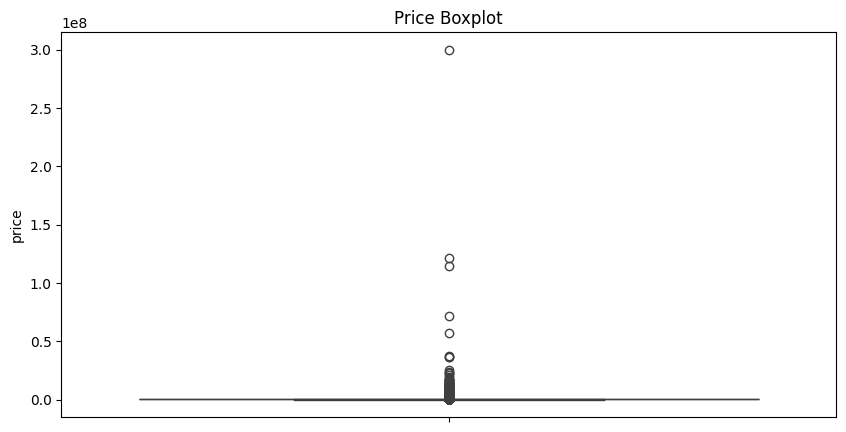

In [10]:
# first of all checking the range of the price
plt.figure(figsize=(10, 5))
sns.boxplot(df['price'])
plt.title('Price Boxplot')
plt.show()

In [11]:
# removing the outliers from the price
df = df[df['price'] < 1000000]

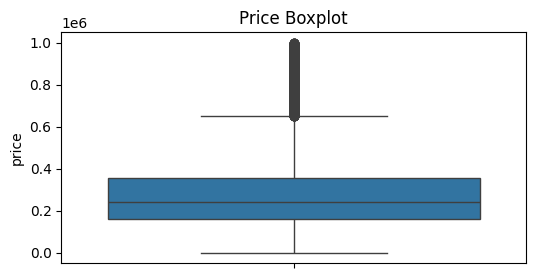

In [12]:
# first of all checking the range of the price
plt.figure(figsize=(6, 3))
sns.boxplot(df['price'])
plt.title('Price Boxplot')
plt.show()

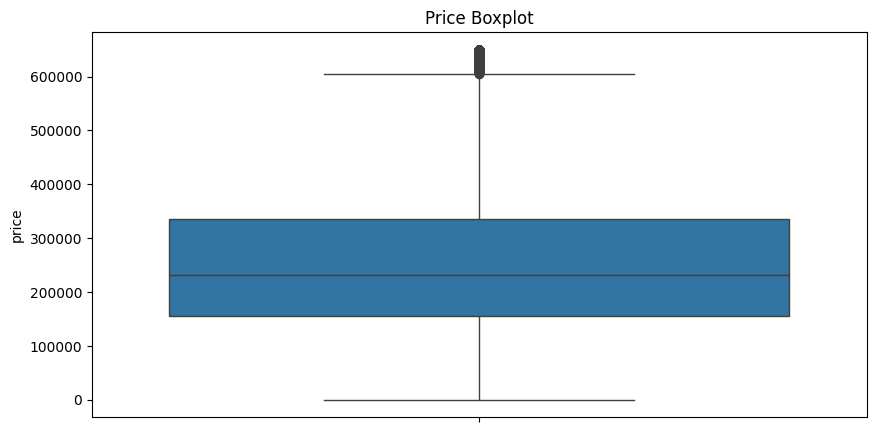

In [13]:
# removing ouliers using IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['price'] >= (Q1 - 1.5 * IQR)) & (df['price'] <= (Q3 + 1.5 * IQR))]
df.shape

# first of all checking the range of the price
plt.figure(figsize=(10, 5))
sns.boxplot(df['price'])
plt.title('Price Boxplot')
plt.show()

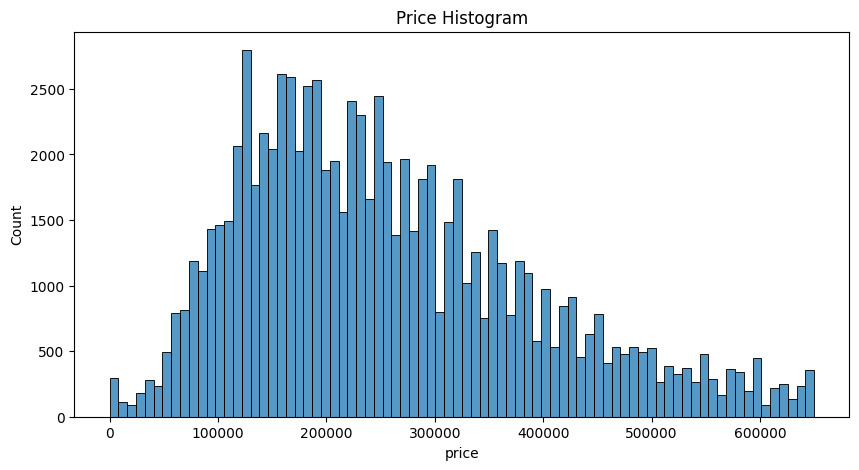

In [14]:
# first of all checking the range of the price
plt.figure(figsize=(10, 5))
sns.histplot(df['price'])
plt.title('Price Histogram')
plt.show()

In [15]:
# Checking for duplicates
# Print the percentage similarity of values (the lower %, the better)
num_unique = df.nunique().sort_values()
print('---- Number Of Unique Values in The Dataset -----')
print(num_unique)

---- Number Of Unique Values in The Dataset -----
freehold             2
new_build            2
property_type        5
county             117
district           358
town               950
date              2542
price             4949
locality          9639
street           41332
postcode         70575
dtype: int64


In [16]:
# checking value counts of categorical columns having less than 10 unique values
for col in df.select_dtypes(include='object').columns:
    if df[col].nunique() < 10:
        print(f'---- {col} ----')
        print(df[col].value_counts())
        print('\n')

---- property_type ----
property_type
D    26784
S    25774
T    21098
F     7443
O     3341
Name: count, dtype: int64


---- new_build ----
new_build
N    73718
Y    10722
Name: count, dtype: int64


---- freehold ----
freehold
F    71672
L    12768
Name: count, dtype: int64




Data Preprocessing

In [17]:
# Transforming date format to datetime
df.date.info()



<class 'pandas.core.series.Series'>
Index: 84440 entries, 1 to 89998
Series name: date
Non-Null Count  Dtype 
--------------  ----- 
84440 non-null  object
dtypes: object(1)
memory usage: 1.3+ MB


In [18]:
# converting the date column to datetime
df['date'] = pd.to_datetime(df['date'])

**Feature Engineering**

In [19]:
# extracting year and month from the date column
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# dropping the date column
df.drop('date', axis=1, inplace=True)

df.head()

,price,postcode,property_type,new_build,freehold,street,locality,town,district,county,year,month
1,160000,SA11 4BD,T,N,F,GORED COTTAGES,MELINCOURT,NEATH,NEATH PORT TALBOT,NEATH PORT TALBOT,2023,2
2,176500,ME3 0DQ,S,N,F,GREEN LANE,ISLE OF GRAIN,ROCHESTER,MEDWAY,MEDWAY,2015,1
3,625000,RH20 3EU,D,N,F,LINFIELD COPSE,THAKEHAM,PULBOROUGH,HORSHAM,WEST SUSSEX,2021,10
4,202000,SN13 8EN,S,N,F,CLYDESDALE ROAD,BOX,CORSHAM,WILTSHIRE,WILTSHIRE,2019,9
5,249950,LS12 5FA,S,Y,F,FARNLEY PARK VIEW,FARNLEY,LEEDS,LEEDS,WEST YORKSHIRE,2019,9


**Feature Encoding**

In [20]:
# checking the object columns , and make two two list of cat columns one having 2 categories and other having more than 2 categories
cat_cols_2 = []
cat_cols_more_than_2 = []
for col in df.select_dtypes(include='object').columns:
    if df[col].nunique() == 2:
        cat_cols_2.append(col)
    else:
        cat_cols_more_than_2.append(col)

print(cat_cols_2)
print(cat_cols_more_than_2)

['new_build', 'freehold']
['postcode', 'property_type', 'street', 'locality', 'town', 'district', 'county']


In [21]:
# checking the unique values of the columns having 2 categories
for col in cat_cols_2:
    print(f'---- {col} ----')
    print(df[col].value_counts())
    print('\n')

---- new_build ----
new_build
N    73718
Y    10722
Name: count, dtype: int64


---- freehold ----
freehold
F    71672
L    12768
Name: count, dtype: int64




    **Encoding Method**
    One Hot Encoding : property_type
    Binary Encoding : new_build, freehold
    Target Encoding : town, district, county, street, locality, postcode
    Ordinal Encoding : month, year



In [22]:
# applying one hot encoding on property_type

df = pd.get_dummies(df, columns=['property_type'], drop_first=True)

df.head()

,price,postcode,new_build,freehold,street,locality,town,district,county,year,month,property_type_F,property_type_O,property_type_S,property_type_T
1,160000,SA11 4BD,N,F,GORED COTTAGES,MELINCOURT,NEATH,NEATH PORT TALBOT,NEATH PORT TALBOT,2023,2,False,False,False,True
2,176500,ME3 0DQ,N,F,GREEN LANE,ISLE OF GRAIN,ROCHESTER,MEDWAY,MEDWAY,2015,1,False,False,True,False
3,625000,RH20 3EU,N,F,LINFIELD COPSE,THAKEHAM,PULBOROUGH,HORSHAM,WEST SUSSEX,2021,10,False,False,False,False
4,202000,SN13 8EN,N,F,CLYDESDALE ROAD,BOX,CORSHAM,WILTSHIRE,WILTSHIRE,2019,9,False,False,True,False
5,249950,LS12 5FA,Y,F,FARNLEY PARK VIEW,FARNLEY,LEEDS,LEEDS,WEST YORKSHIRE,2019,9,False,False,True,False


In [23]:
# applying binary encoding on new_build and freehold
be = BinaryEncoder()

# Fit and transform each column separately
df_new_build = be.fit_transform(df[['new_build']])
df_freehold = be.fit_transform(df[['freehold']])

# Drop original columns and concatenate the new binary encoded columns
df.drop(['new_build', 'freehold'], axis=1, inplace=True)
df = pd.concat([df, df_new_build, df_freehold], axis=1)

df.head(2)


,price,postcode,street,locality,town,district,county,year,month,property_type_F,property_type_O,property_type_S,property_type_T,new_build_0,new_build_1,freehold_0,freehold_1
1,160000,SA11 4BD,GORED COTTAGES,MELINCOURT,NEATH,NEATH PORT TALBOT,NEATH PORT TALBOT,2023,2,False,False,False,True,0,1,0,1
2,176500,ME3 0DQ,GREEN LANE,ISLE OF GRAIN,ROCHESTER,MEDWAY,MEDWAY,2015,1,False,False,True,False,0,1,0,1


In [24]:

df.head(2)

,price,postcode,street,locality,town,district,county,year,month,property_type_F,property_type_O,property_type_S,property_type_T,new_build_0,new_build_1,freehold_0,freehold_1
1,160000,SA11 4BD,GORED COTTAGES,MELINCOURT,NEATH,NEATH PORT TALBOT,NEATH PORT TALBOT,2023,2,False,False,False,True,0,1,0,1
2,176500,ME3 0DQ,GREEN LANE,ISLE OF GRAIN,ROCHESTER,MEDWAY,MEDWAY,2015,1,False,False,True,False,0,1,0,1


In [25]:
# now applying target encoding on town, district, county, street, locality, postcode
te = TargetEncoder()

# Fit and transform each column separately
df_town = te.fit_transform(df['town'], df['price'])
df_district = te.fit_transform(df['district'], df['price'])
df_county = te.fit_transform(df['county'], df['price'])
df_street = te.fit_transform(df['street'], df['price'])

# Drop original columns and concatenate the new target encoded columns
df.drop(['town', 'district', 'county', 'street'], axis=1, inplace=True)
df = pd.concat([df, df_town, df_district, df_county, df_street], axis=1)

df.head(2)

,price,postcode,locality,year,month,property_type_F,property_type_O,property_type_S,property_type_T,new_build_0,new_build_1,freehold_0,freehold_1,town,district,county,street
1,160000,SA11 4BD,MELINCOURT,2023,2,False,False,False,True,0,1,0,1,139561.191540,141657.139319,141657.139319,244226.95590
2,176500,ME3 0DQ,ISLE OF GRAIN,2015,1,False,False,True,False,0,1,0,1,298038.868304,303562.638806,303562.638806,249150.36779


In [26]:
# now applying target encoding on locality and postcode
te = TargetEncoder()

# Fit and transform each column separately
df_locality = te.fit_transform(df['locality'], df['price'])
df_postcode = te.fit_transform(df['postcode'], df['price'])

# Drop original columns and concatenate the new target encoded columns
df.drop(['locality', 'postcode'], axis=1, inplace=True)

df = pd.concat([df, df_locality, df_postcode], axis=1)

df.head(2)

,price,year,month,property_type_F,property_type_O,property_type_S,property_type_T,new_build_0,new_build_1,freehold_0,freehold_1,town,district,county,street,locality,postcode
1,160000,2023,2,False,False,False,True,0,1,0,1,139561.191540,141657.139319,141657.139319,244226.95590,233681.958739,244226.955900
2,176500,2015,1,False,False,True,False,0,1,0,1,298038.868304,303562.638806,303562.638806,249150.36779,244899.589684,246418.260562


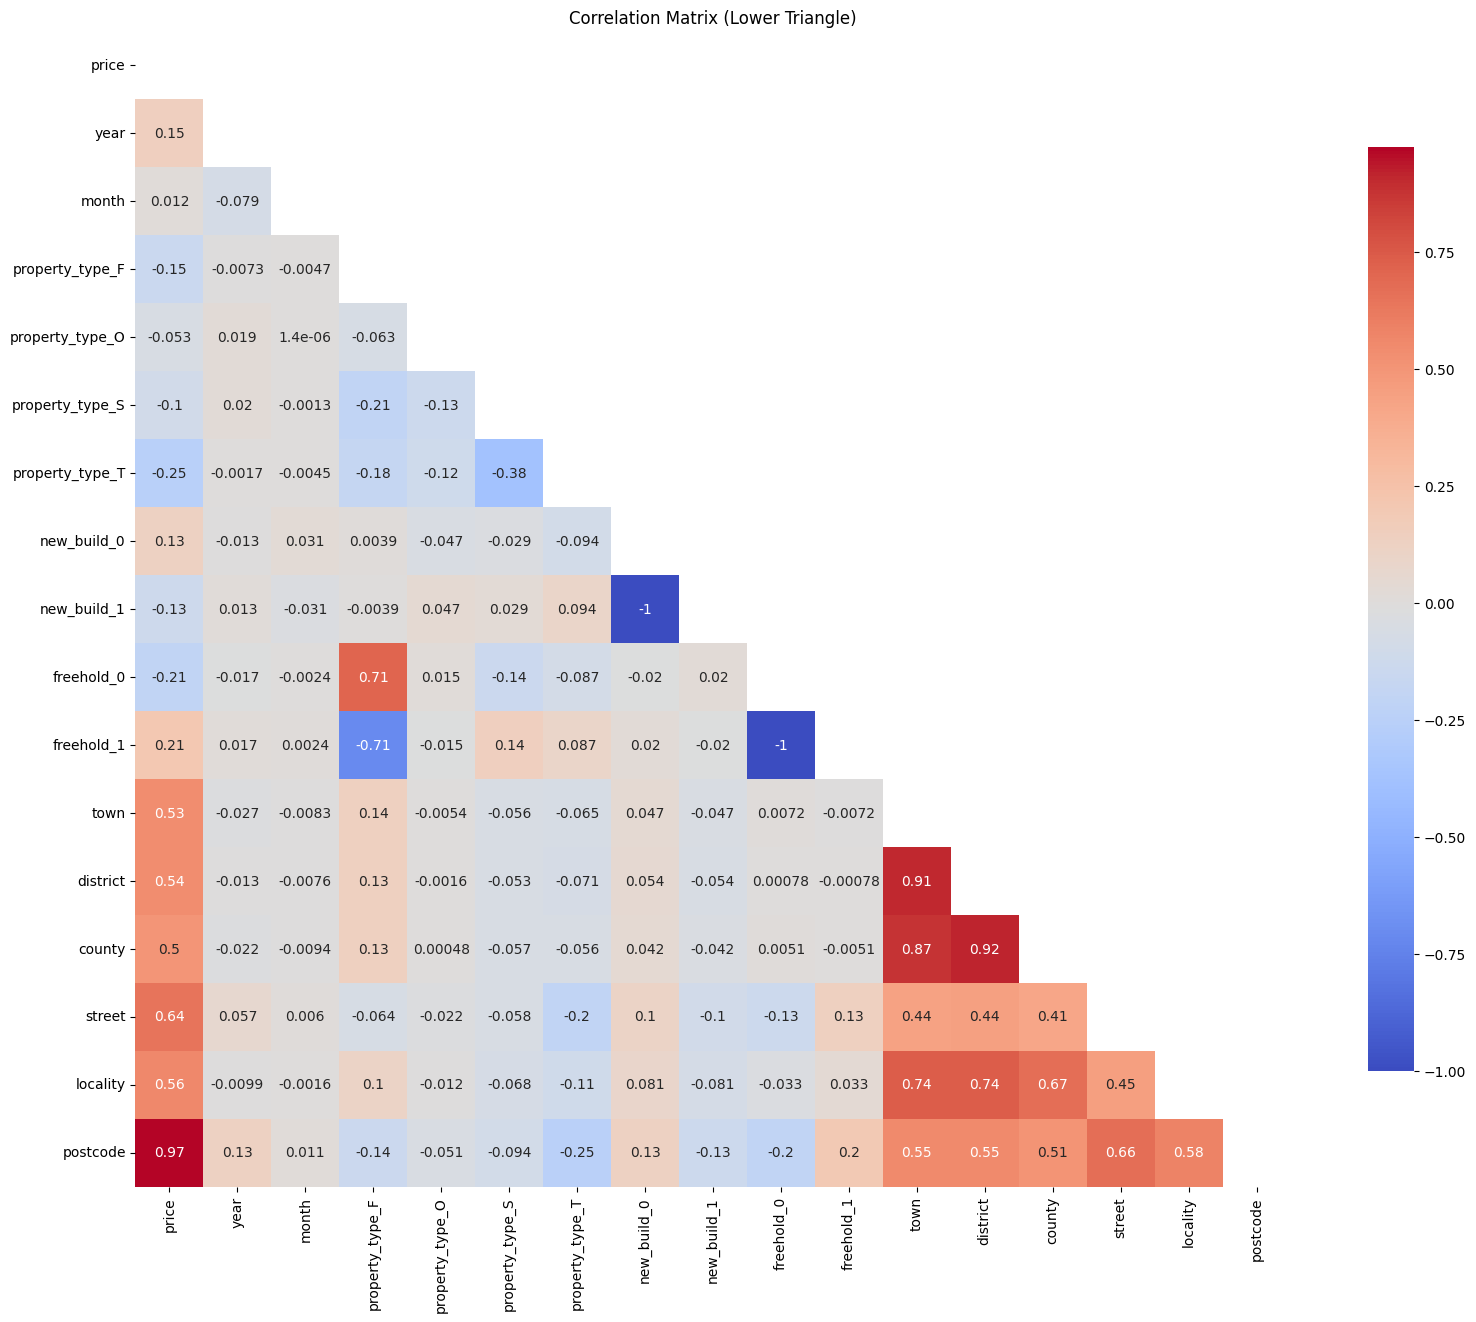

In [27]:
# Calculate the correlation matrix
corr = df.corr()

# Create a mask to cover the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set the title and show the plot
plt.title('Correlation Matrix (Lower Triangle)')
plt.show()

**Data Normalization**

In [28]:
# importing library
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# import add_trace
from plotly.graph_objs import Scatter



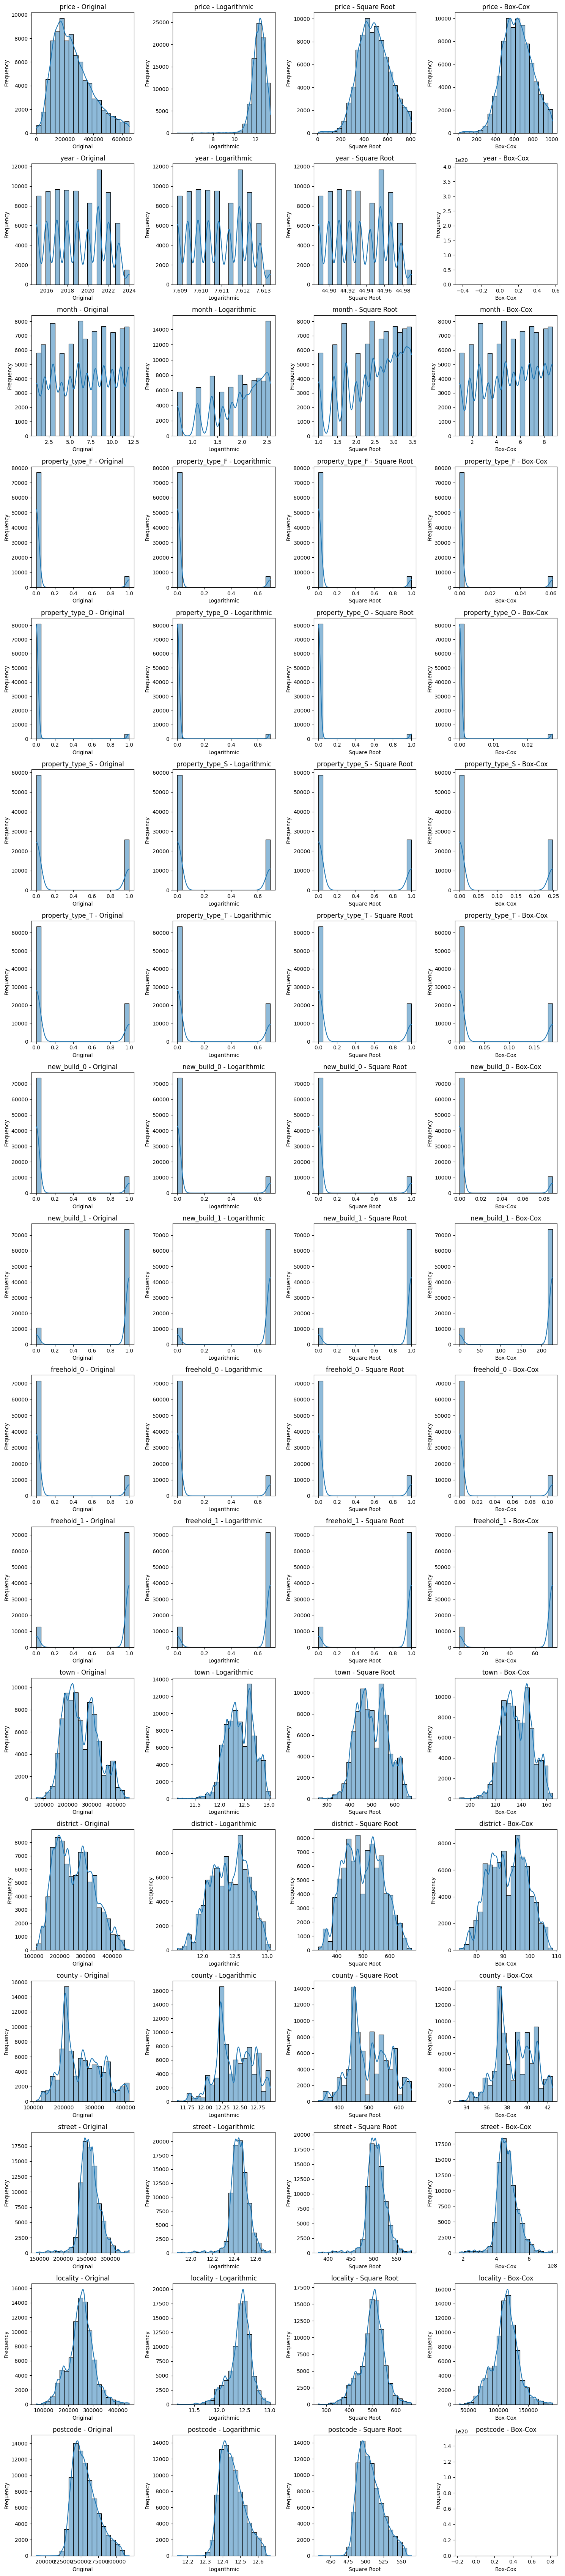

In [29]:
def check_transformations(df):
    transformations = {
        'Original': lambda x: x,
        'Logarithmic': lambda x: np.log(x + 1),  # log(x) + 1 to avoid log(0)
        'Square Root': lambda x: np.sqrt(x),
        'Box-Cox': lambda x: stats.boxcox(x + 1)[0]  # Box-Cox requires positive values
    }

    # Set up the number of rows and columns for the subplots
    num_cols = len(df.columns)
    num_transforms = len(transformations)

    # Create a figure with subplots
    fig, axes = plt.subplots(num_cols, num_transforms, figsize=(15, 4 * num_cols))

    # Add histograms for each transformation
    for i, col in enumerate(df.columns):
        for j, (trans_name, transform_func) in enumerate(transformations.items()):
            transformed_data = transform_func(df[col])

            # Plot the histogram using seaborn
            sns.histplot(transformed_data, ax=axes[i, j], bins=20, kde=True)
            axes[i, j].set_title(f"{col} - {trans_name}")
            axes[i, j].set_xlabel(trans_name)
            axes[i, j].set_ylabel('Frequency')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame
check_transformations(df)

In [30]:
# Checking Skewness of the price column
df['price'].skew()

np.float64(0.7490004657140983)

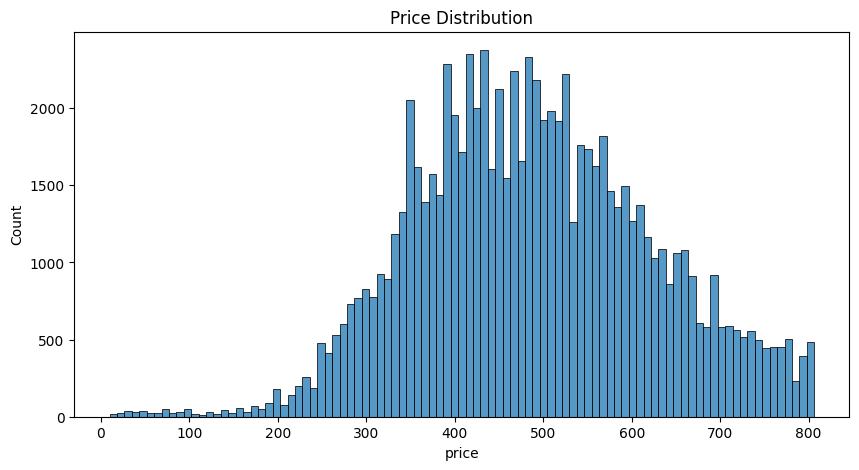

In [31]:
# using sqrt transformation method for price column
df['price'] = np.sqrt(df['price'])

# checking the distribution of the price column
plt.figure(figsize=(10, 5))
sns.histplot(df['price'])
plt.title('Price Distribution')
plt.show()

In [32]:
# checking the skewness of the price column
print(f"Skewness: {df['price'].skew()}")

Skewness: 0.08390414174892526


In [33]:
# viewing the shape
df.shape

(84440, 17)

**Model Training**

In [34]:
import warnings
warnings.filterwarnings('ignore')

# Split the data into features and target

X = df.drop('price', axis=1)
y = df['price']
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Create a list of models to evaluate, regression models

models = [
    ('Linear Regression', LinearRegression()),
    ('Lasso', Lasso(random_state=42)),
    ('Ridge', Ridge(random_state=42)),
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('LightGBM', LGBMRegressor(random_state=42)),
    ('CatBoost', CatBoostRegressor(random_state=42, verbose=0))
]

# Create a dictionary to store the best model
best_model = None
best_rmse = np.inf

# Iterate over the models and evaluate their performance

for name, model in models:
    # Fit the pipeline on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Evalation metics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the performance metrics
    print("Model:", name)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2 Score:", r2)

    # Check if the current model has the best RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model

    # Print a separator
    print('-' * 40)

# Retrieve the best model
print("Best Model:", best_model)

Model: Linear Regression
RMSE: 35.67929345512386
MAE: 22.84480817439509
R2 Score: 0.9279227366223626
----------------------------------------
Model: Lasso
RMSE: 36.84390109268004
MAE: 23.488314249700508
R2 Score: 0.9231405958354731
----------------------------------------
Model: Ridge
RMSE: 35.679310368654775
MAE: 22.844410504839114
R2 Score: 0.9279226682868551
----------------------------------------
Model: Decision Tree
RMSE: 44.8579174373913
MAE: 21.252702703543576
R2 Score: 0.8860684482918765
----------------------------------------
Model: Random Forest
RMSE: 32.781973039318636
MAE: 15.985569537224643
R2 Score: 0.9391534476708852
----------------------------------------
Model: Gradient Boosting
RMSE: 30.132251799167502
MAE: 15.183215705407815
R2 Score: 0.948592205313914
----------------------------------------
Model: XGBoost
RMSE: 30.420553050822843
MAE: 16.509428151680794
R2 Score: 0.947603773783999
----------------------------------------
[LightGBM] [Info] Auto-choosing col-wise 

**Saving the best model for app deployment**

In [36]:
model.save_model("catboost_model.cbm")
# Later in app
#model.load_model("catboost_model.cbm")


**Models Comparison based on Metrics Evaluation**

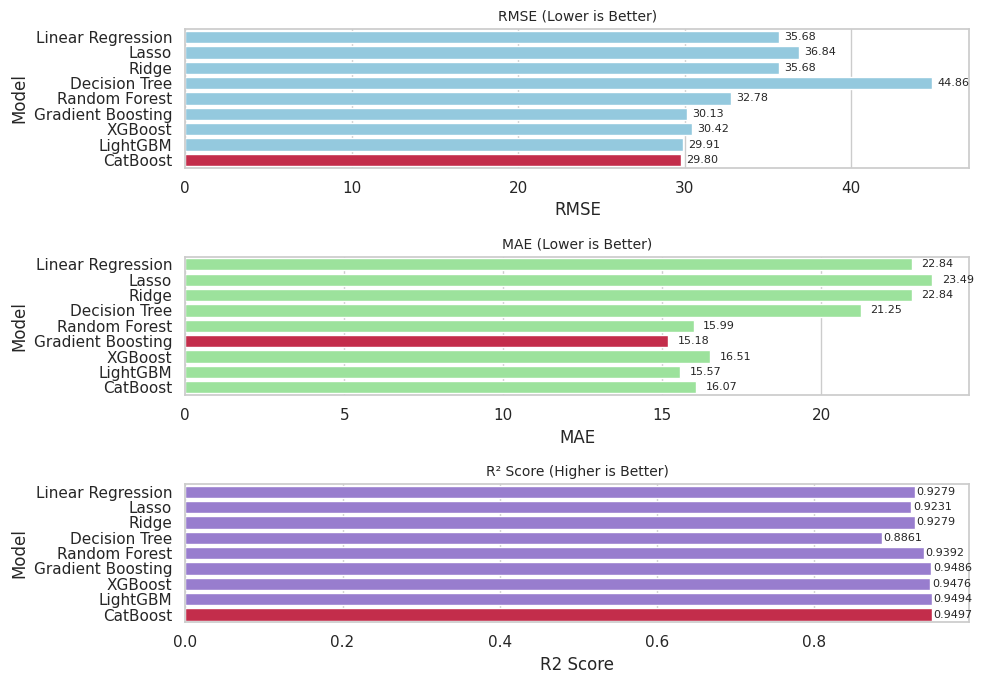

In [37]:
# Models Comparison based on metrics evaluation

# Data
data = {
    'Model': [
        'Linear Regression', 'Lasso', 'Ridge', 'Decision Tree',
        'Random Forest', 'Gradient Boosting', 'XGBoost',
        'LightGBM', 'CatBoost'
    ],
    'RMSE': [
        35.679, 36.844, 35.679, 44.858,
        32.782, 30.132, 30.421, 29.905, 29.802
    ],
    'MAE': [
        22.845, 23.488, 22.844, 21.253,
        15.986, 15.183, 16.509, 15.569, 16.075
    ],
    'R2 Score': [
        0.9279, 0.9231, 0.9279, 0.8861,
        0.9392, 0.9486, 0.9476, 0.9494, 0.9497
    ]
}

df = pd.DataFrame(data)

# Best model detection
best_rmse_model = df.loc[df['RMSE'].idxmin(), 'Model']
best_mae_model = df.loc[df['MAE'].idxmin(), 'Model']
best_r2_model = df.loc[df['R2 Score'].idxmax(), 'Model']

# Plot settings
sns.set(style="whitegrid")
plt.figure(figsize=(10, 7))

# RMSE plot
plt.subplot(3, 1, 1)
colors = ['crimson' if model == best_rmse_model else 'skyblue' for model in df['Model']]
sns.barplot(x='RMSE', y='Model', data=df, palette=colors)
plt.title('RMSE (Lower is Better)', fontsize=10)
for i, v in enumerate(df['RMSE']):
    plt.text(v + 0.3, i, f"{v:.2f}", fontsize=8, va='center')

# MAE plot
plt.subplot(3, 1, 2)
colors = ['crimson' if model == best_mae_model else 'lightgreen' for model in df['Model']]
sns.barplot(x='MAE', y='Model', data=df, palette=colors)
plt.title('MAE (Lower is Better)', fontsize=10)
for i, v in enumerate(df['MAE']):
    plt.text(v + 0.3, i, f"{v:.2f}", fontsize=8, va='center')

# R2 plot
plt.subplot(3, 1, 3)
colors = ['crimson' if model == best_r2_model else 'mediumpurple' for model in df['Model']]
sns.barplot(x='R2 Score', y='Model', data=df, palette=colors)
plt.title('R² Score (Higher is Better)', fontsize=10)
for i, v in enumerate(df['R2 Score']):
    plt.text(v + 0.002, i, f"{v:.4f}", fontsize=8, va='center')

plt.tight_layout()
plt.show()



**Comparing Prediction with Actual Valuses**

In [38]:

results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print(results.head(10))  # View first 10 rows


           Actual   Predicted
37609  526.307895  522.672705
55496  599.995833  573.974351
65044  522.494019  524.747593
65643  260.768096  270.679097
11988  541.294744  579.202017
31997  514.781507  575.509131
76706  431.856458  430.878778
25335  496.990946  491.261756
48467  484.767986  478.937031
60796  380.788655  394.388247


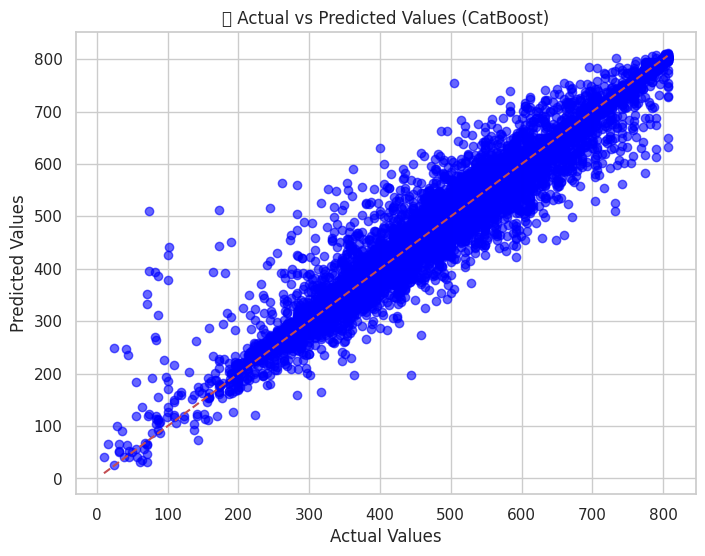

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("📍 Actual vs Predicted Values (CatBoost)")
plt.grid(True)
plt.show()


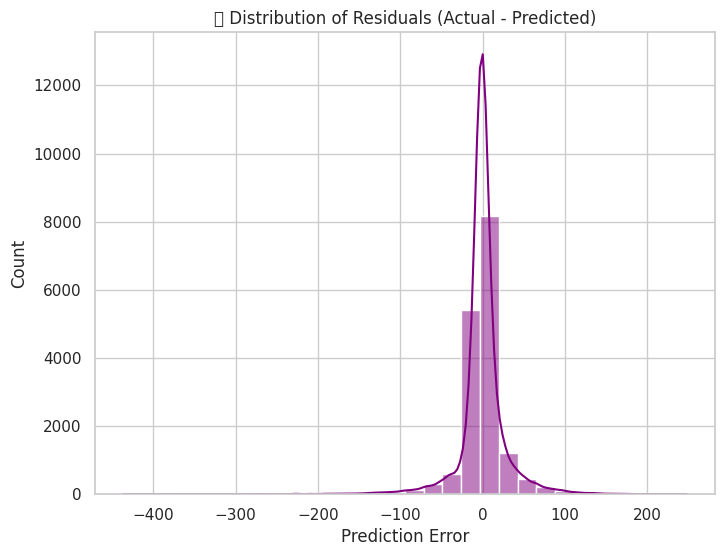

In [40]:
# Residual Plot ( Prediction Errors)

import seaborn as sns

residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.title("📉 Distribution of Residuals (Actual - Predicted)")
plt.xlabel("Prediction Error")
plt.grid(True)
plt.show()


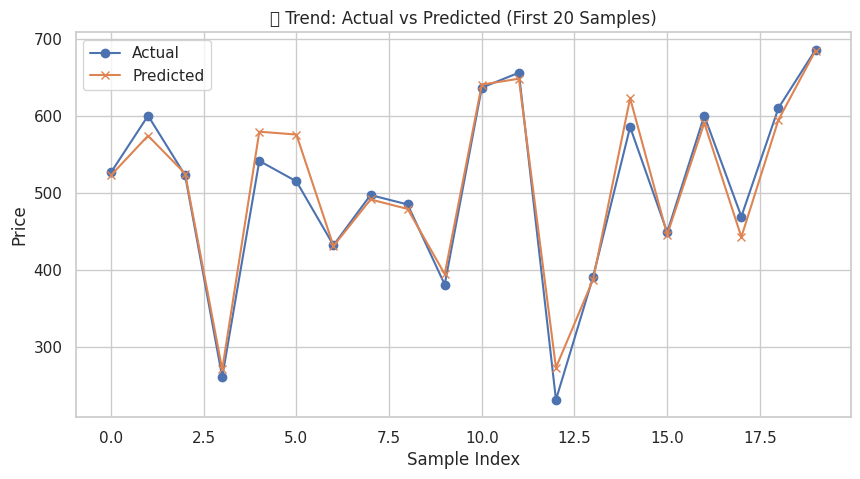

In [41]:
# Line Plot (Tren Comparison)
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:20], label='Actual', marker='o')
plt.plot(y_pred[:20], label='Predicted', marker='x')
plt.title("📈 Trend: Actual vs Predicted (First 20 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
